5.1
Note that the mean and standard deviation should be estimated from the training data and then applied to both datasets.  Explain why this is the case

Training dataset's standard deviation and mean should be used for both set since the distribution that the model was trained on relied on the mean and the standard deviation from the training set, which means that the classification decision making is based on the same distribution. Otherwise, if for testing set we use the testing set's standard deviation and the mean, we will get lower accuracy and higher classification error. 

In [1]:
#specify paths 

import numpy as np
path_test ="./test.txt"
path_train ="./train.txt"

In [2]:

def count_lines(file_path):
    line_count = 0
    with open(file_path, 'r') as file:
        for line in file:
            line_count += 1
    return line_count

rows_train = count_lines(path_train)
rows_test =count_lines(path_test)


In [3]:
# load the data

def read_data(path, num_rows):
    y = np.array([])
    num_cols = 60
    X = np.zeros((num_rows, num_cols))  

    with open(path, 'r') as file:
        for line_num, line in enumerate(file):
            temp_arr = line.split()
            y = np.append(y, int(temp_arr[0]))
            temp_arr.pop(0)
            
            for index, value in enumerate(temp_arr):
                X[line_num, index] = float(value.split(":")[1])
    
    return X, y

x_train, y_train = read_data(path_train,rows_train)
x_test, y_test = read_data(path_test,rows_test)

In [4]:
#Computing the mean of each feature and subtracting 
# it from all values of this feature.
mean_train = np.mean(x_train, axis=0)
#subtract mean from x_train and x_test
x_train_c = x_train- mean_train
x_test_c  = x_test - mean_train

In [5]:
# calculate stdev train
num_cols = 60


stdev_train = np.zeros(num_cols)
for col in range(num_cols):
    sum_squares = np.sum(x_train_c[:,col]**2)
    var = sum_squares/(rows_train-1)
    stdev_train[col] = np.sqrt(var)
    
# calculate stdev test
stdev_test = np.zeros(num_cols)
for col in range(num_cols):
    sum_squares = np.sum(x_test_c[:,col]**2)
    var = sum_squares/(rows_test-1)
    stdev_test[col] = np.sqrt(var)
    
x_train_c[1]

array([-1.513,  0.54 ,  0.46 ,  1.476, -0.536, -1.533, -0.492, -0.556,
        1.463,  0.473, -0.568, -0.596, -0.567, -1.515, -0.56 ,  1.424,
        1.333,  0.318, -0.681, -1.709, -0.664, -1.595,  0.39 ,  0.306,
       -1.632, -0.699,  0.537,  0.357,  2.014, -0.289, -1.283,  0.108,
        0.735, -1.286, -1.397,  0.352, -1.416,  1.488, -0.492, -0.537,
        1.484, -0.538, -1.508, -1.568, -1.47 ,  0.546,  0.543,  0.524,
        0.525, -1.51 ,  1.509,  0.588,  1.507,  1.561,  1.567, -1.496,
        0.552,  1.477, -1.488, -1.464])

In [7]:
# 5.1 mean and the standard deviation of the 2nd and 9th features
# on the training data.
print("Mean of 2nd and 9th features are: %.5f and %.5f" % (mean_train[1], mean_train[8]))
print("Standard Deviation of 2nd and 9th features are: %.5f and %.5f" % (stdev_train[1], stdev_train[8]))

Mean of 2nd and 9th features are: 2.46000 and 2.53700
Standard Deviation of 2nd and 9th features are: 1.12235 and 1.10628


In [8]:
#Implement linear SVM
!pip install cvxopt

In [9]:
import numpy as np
import os
from sklearn.datasets import load_svmlight_file
import cvxopt
'''
Example for reading data and the corresponding labels
'''
DATA_DIR = '.'
data_train, label_train = load_svmlight_file(os.path.join(DATA_DIR, 'train.txt'),n_features=60) 

def train_svm(train_data, train_label, C):
    '''
  Train linear SVM (primal form)
    
  Argument:
    train_data: N*D matrix, each row as a sample and each column as a feature
    train_label: N*1 vector, each row as a label
    C: tradeoff parameter (on slack variable side)

  Return:
    w: feature vector (column vector)
    b: bias term
    '''
    N, d = train_data.shape
    y = train_label
    P = np.zeros((N+d+1, N+d+1))
    for i in  range(d):
        P[i,i] = 1
    P = cvxopt.matrix(P)
    y = train_label
    X = train_data
    q = np.zeros(N+d+1)
    q[(d+1):] = C
    q = cvxopt.matrix(q)
    
    
    # create matrix G
    G1 = np.zeros((N,N+d+1))
    for i in range (N):
        G1[i,:d] = -y[i]*X[i]
        G1[i,d] = -y[i]
        G1[i,d+1+i] = -1
    
    G2 = np.zeros((N,N+d+1))
    for i in range(N):
        G2[i, d+1+i] = -1
        
    G = np.vstack((G1, G2))
    G = cvxopt.matrix(G)
    h = np.zeros(2*N)
    h[:N] = -1
    h = cvxopt.matrix(h)
    
    
    # extract w and b
    solution = cvxopt.solvers.qp(P, q, G, h)
    w = np.array(solution['x'][:d])
    b = solution['x'][d]
    return w, b

def test_svm(test_data, test_label, w, b):
    '''
  Test linear SVM

  Argument:
    test_data: M*D matrix, each row as a sample and each column as a feature
    test_label: M*1 vector, each row as a label
    w: feature vector
    b: bias term

  Return:
    test_accuracy: a float between [0, 1] representing the test accuracy
    '''
    prediction = np.dot(test_data, w) + b
    prediction[prediction>=0] = 1
    prediction[prediction<0] = -1
    # calcilate the number of predictions that match the label
    correct_pred = 0
    for i in range(len(prediction)):
        if prediction[i] == test_label[i]:
            correct_pred+=1
    
    test_accuracy = correct_pred/len(prediction)
    return test_accuracy
    

In [10]:
w,b = train_svm(x_train_c,y_train, C=1)

     pcost       dcost       gap    pres   dres
 0: -4.9860e+02  2.4955e+03  1e+04  4e+00  6e+01
 1:  1.2847e+03 -4.8667e+02  2e+03  6e-01  8e+00
 2:  5.7774e+02  2.4736e+02  4e+02  6e-02  9e-01
 3:  4.2678e+02  3.3211e+02  1e+02  1e-02  2e-01
 4:  4.0080e+02  3.5350e+02  5e+01  6e-03  9e-02
 5:  3.8775e+02  3.6326e+02  3e+01  3e-03  4e-02
 6:  3.7982e+02  3.6898e+02  1e+01  9e-04  1e-02
 7:  3.7648e+02  3.7140e+02  5e+00  3e-04  5e-03
 8:  3.7446e+02  3.7295e+02  2e+00  5e-05  8e-04
 9:  3.7401e+02  3.7329e+02  7e-01  2e-05  2e-04
10:  3.7374e+02  3.7351e+02  2e-01  5e-06  7e-05
11:  3.7366e+02  3.7358e+02  8e-02  1e-06  2e-05
12:  3.7362e+02  3.7361e+02  1e-02  1e-15  9e-13
13:  3.7362e+02  3.7361e+02  2e-03  9e-16  5e-13
14:  3.7362e+02  3.7362e+02  3e-05  1e-15  2e-12
Optimal solution found.


In [11]:
print(w)
print(b)

[[-0.04711602]
 [ 0.00534461]
 [-0.12712492]
 [-0.03850506]
 [-0.11616324]
 [-0.00154075]
 [-0.02051037]
 [ 0.08125871]
 [-0.01035096]
 [ 0.03268464]
 [-0.07782362]
 [-0.0589606 ]
 [ 0.13953078]
 [-0.07960447]
 [-0.134555  ]
 [-0.11521771]
 [-0.07542658]
 [-0.15084653]
 [-0.16948543]
 [ 0.00977278]
 [-0.03550786]
 [-0.30238639]
 [-0.23514275]
 [-0.06881472]
 [-0.18110149]
 [-0.15802188]
 [ 0.17708806]
 [-0.36707006]
 [ 0.72898312]
 [ 0.48755026]
 [ 0.43532252]
 [-0.73603102]
 [ 0.3689257 ]
 [ 0.38402666]
 [ 0.06591366]
 [-0.2362861 ]
 [-0.03716076]
 [-0.03867921]
 [-0.16328774]
 [-0.21058313]
 [ 0.04109155]
 [-0.06481035]
 [-0.07932463]
 [-0.02369236]
 [ 0.07980488]
 [ 0.03920379]
 [-0.03107073]
 [ 0.11451977]
 [ 0.089351  ]
 [ 0.02328746]
 [-0.02585032]
 [-0.07353927]
 [ 0.04263532]
 [ 0.02926066]
 [ 0.03987334]
 [-0.11596793]
 [-0.0328125 ]
 [ 0.08293705]
 [ 0.04862539]
 [-0.08780938]]
0.21227945158118347


In [12]:
b

0.21227945158118347

In [13]:
test_svm(x_test_c, y_test, w,b)

0.8468965517241379

In [14]:
# 5.3

In [15]:
power = [i for i in range(-6,4)]
C_array = [4**j for j in power]

In [16]:
split_x_train = np.array_split(x_train_c, 10)
split_y_train = np.array_split(y_train, 10)
#accuracy matrix: num rows = differnet C values, num col same C, different fold
accuracy_mat = np.zeros((len(C_array), 10))
for index, C_val in enumerate(C_array):
    for i in range(10):
        # i is the index for the validation 
        # arr contains the indices that need to be included in x_train and y_train
        arr = [k for k in range(10) if k != i]
        
        x_train_fold = np.concatenate([split_x_train[l] for l in arr])
        y_train_fold = np.concatenate([split_y_train[l] for l in arr])
        
        x_valid = split_x_train[i]
        y_valid = split_y_train[i]

        w_temp, b_temp = train_svm(x_train_fold, y_train_fold, C_val)
        accuracy_temp = test_svm(x_valid, y_valid, w_temp, b_temp)
        accuracy_mat[index,i] = accuracy_temp

     pcost       dcost       gap    pres   dres
 0:  1.9596e-01  2.2107e+02  7e+03  3e+00  2e+03
 1:  6.2951e-01 -7.1799e+01  7e+01  3e-02  2e+01
 2:  5.9259e-01 -2.8119e+00  3e+00  1e-03  8e-01
 3:  4.6929e-01  1.5388e-01  3e-01  2e-15  4e-16
 4:  2.1594e-01  1.7454e-01  4e-02  1e-15  8e-17
 5:  2.0386e-01  1.8304e-01  2e-02  6e-16  1e-16
 6:  2.0127e-01  1.8510e-01  2e-02  5e-16  1e-16
 7:  1.9584e-01  1.8894e-01  7e-03  5e-16  9e-17
 8:  1.9356e-01  1.9073e-01  3e-03  4e-16  8e-17
 9:  1.9247e-01  1.9157e-01  9e-04  5e-16  2e-16
10:  1.9204e-01  1.9194e-01  1e-04  5e-16  1e-16
11:  1.9199e-01  1.9198e-01  3e-06  6e-16  2e-16
12:  1.9199e-01  1.9199e-01  5e-08  5e-16  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9332e-01  2.2730e+02  7e+03  3e+00  2e+03
 1:  6.1674e-01 -6.8591e+01  7e+01  3e-02  2e+01
 2:  5.8113e-01 -2.8661e+00  3e+00  1e-03  8e-01
 3:  4.6427e-01  1.5457e-01  3e-01  2e-15  4e-16
 4:  2.1543e-01  1.7569e-01  4e-02  1e-15  6e-1

 9:  5.9886e-01  5.9886e-01  2e-06  5e-16  3e-15
10:  5.9886e-01  5.9886e-01  5e-08  5e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6080e-01  2.2466e+02  7e+03  3e+00  2e+03
 1:  2.0938e+00 -6.9533e+01  7e+01  3e-02  2e+01
 2:  2.0272e+00 -7.0437e-01  3e+00  5e-04  3e-01
 3:  7.8112e-01  4.9615e-01  3e-01  1e-15  4e-16
 4:  6.3277e-01  5.6966e-01  6e-02  6e-16  2e-16
 5:  6.0936e-01  5.8853e-01  2e-02  5e-16  2e-16
 6:  6.0006e-01  5.9627e-01  4e-03  5e-16  4e-16
 7:  5.9827e-01  5.9784e-01  4e-04  4e-16  7e-16
 8:  5.9806e-01  5.9804e-01  2e-05  5e-16  2e-15
 9:  5.9805e-01  5.9805e-01  6e-07  5e-16  9e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6014e-01  2.2670e+02  7e+03  3e+00  2e+03
 1:  2.0639e+00 -6.7251e+01  7e+01  3e-02  2e+01
 2:  1.9964e+00 -7.8860e-01  3e+00  5e-04  4e-01
 3:  8.0328e-01  4.9496e-01  3e-01  1e-15  4e-16
 4:  6.3229e-01  5.6849e-01  6e-02  5e-16  3e-16
 5:  6.1081e-01  5.8621

 2:  6.7139e+00 -2.8377e+00  1e+01  2e-03  1e+00
 3:  2.5063e+00  1.4723e+00  1e+00  1e-15  1e-15
 4:  1.9418e+00  1.7142e+00  2e-01  6e-16  6e-16
 5:  1.8633e+00  1.7838e+00  8e-02  5e-16  9e-16
 6:  1.8294e+00  1.8117e+00  2e-02  6e-16  1e-15
 7:  1.8222e+00  1.8177e+00  4e-03  5e-16  3e-15
 8:  1.8201e+00  1.8196e+00  5e-04  5e-16  6e-15
 9:  1.8198e+00  1.8198e+00  6e-05  5e-16  2e-14
10:  1.8198e+00  1.8198e+00  2e-06  6e-16  5e-14
11:  1.8198e+00  1.8198e+00  5e-08  6e-16  4e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0214e+00  2.3404e+02  7e+03  3e+00  2e+03
 1:  7.9865e+00 -7.5054e+01  8e+01  3e-02  2e+01
 2:  6.9494e+00 -2.7774e+00  1e+01  2e-03  1e+00
 3:  2.4963e+00  1.4928e+00  1e+00  1e-15  8e-16
 4:  1.9715e+00  1.7408e+00  2e-01  7e-16  7e-16
 5:  1.8901e+00  1.8111e+00  8e-02  5e-16  9e-16
 6:  1.8568e+00  1.8372e+00  2e-02  5e-16  1e-15
 7:  1.8478e+00  1.8446e+00  3e-03  6e-16  3e-15
 8:  1.8465e+00  1.8456e+00  9e-04  5e-16  7e-

 3:  7.5435e+00  4.9737e+00  3e+00  1e-04  9e-02
 4:  6.7502e+00  5.6078e+00  1e+00  5e-05  3e-02
 5:  6.3833e+00  5.8728e+00  5e-01  2e-05  1e-02
 6:  6.1921e+00  6.0184e+00  2e-01  5e-06  3e-03
 7:  6.1266e+00  6.0699e+00  6e-02  6e-07  4e-04
 8:  6.1044e+00  6.0873e+00  2e-02  1e-07  9e-05
 9:  6.0969e+00  6.0932e+00  4e-03  3e-08  2e-05
10:  6.0952e+00  6.0946e+00  6e-04  3e-09  2e-06
11:  6.0949e+00  6.0949e+00  3e-05  2e-10  1e-07
12:  6.0949e+00  6.0949e+00  4e-07  2e-12  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.4932e+00  2.5605e+02  7e+03  3e+00  2e+03
 1:  3.1234e+01 -1.0641e+02  1e+02  5e-02  3e+01
 2:  2.2238e+01 -5.0532e+00  3e+01  5e-03  3e+00
 3:  7.5412e+00  4.9116e+00  3e+00  1e-04  8e-02
 4:  6.5727e+00  5.6577e+00  9e-01  4e-05  2e-02
 5:  6.3035e+00  5.8691e+00  4e-01  2e-05  1e-02
 6:  6.1428e+00  5.9933e+00  1e-01  5e-06  3e-03
 7:  6.0906e+00  6.0364e+00  5e-02  8e-07  5e-04
 8:  6.0684e+00  6.0541e+00  1e-02  2e-07  1e-

11:  2.1863e+01  2.1863e+01  7e-04  1e-08  3e-06
12:  2.1863e+01  2.1863e+01  3e-05  4e-10  1e-07
13:  2.1863e+01  2.1863e+01  8e-07  1e-11  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1564e+01  3.5033e+02  7e+03  3e+00  1e+03
 1:  1.1802e+02 -2.1213e+02  3e+02  1e-01  3e+01
 2:  7.2275e+01 -5.4556e+00  8e+01  1e-02  5e+00
 3:  2.8582e+01  1.7499e+01  1e+01  2e-03  5e-01
 4:  2.4136e+01  2.0324e+01  4e+00  5e-04  2e-01
 5:  2.3178e+01  2.0966e+01  2e+00  2e-04  8e-02
 6:  2.2342e+01  2.1494e+01  8e-01  5e-05  2e-02
 7:  2.1995e+01  2.1731e+01  3e-01  9e-06  3e-03
 8:  2.1893e+01  2.1804e+01  9e-02  2e-06  6e-04
 9:  2.1854e+01  2.1834e+01  2e-02  3e-07  1e-04
10:  2.1844e+01  2.1842e+01  1e-03  2e-08  6e-06
11:  2.1843e+01  2.1843e+01  6e-05  5e-10  2e-07
12:  2.1843e+01  2.1843e+01  1e-06  9e-12  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2946e+01  7.2477e+02  8e+03  3e+00  2e+02
 1:  4.0819e+02 -4.4789

 7:  8.4836e+01  8.3564e+01  1e+00  7e-05  5e-03
 8:  8.4388e+01  8.3891e+01  5e-01  2e-05  2e-03
 9:  8.4232e+01  8.4008e+01  2e-01  7e-06  6e-04
10:  8.4156e+01  8.4066e+01  9e-02  2e-06  2e-04
11:  8.4117e+01  8.4097e+01  2e-02  4e-07  3e-05
12:  8.4108e+01  8.4105e+01  3e-03  5e-08  4e-06
13:  8.4106e+01  8.4106e+01  2e-04  1e-15  1e-12
14:  8.4106e+01  8.4106e+01  3e-06  1e-15  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5800e+02  2.2351e+03  1e+04  4e+00  6e+01
 1:  1.1384e+03 -4.5037e+02  2e+03  6e-01  8e+00
 2:  5.1938e+02  2.0493e+02  4e+02  7e-02  1e+00
 3:  3.7816e+02  2.8475e+02  1e+02  2e-02  3e-01
 4:  3.5100e+02  3.0693e+02  5e+01  7e-03  1e-01
 5:  3.3975e+02  3.1538e+02  3e+01  3e-03  4e-02
 6:  3.3120e+02  3.2164e+02  1e+01  6e-04  8e-03
 7:  3.2775e+02  3.2405e+02  4e+00  1e-04  2e-03
 8:  3.2661e+02  3.2486e+02  2e+00  3e-05  5e-04
 9:  3.2589e+02  3.2544e+02  5e-01  8e-06  1e-04
10:  3.2570e+02  3.2559e+02  1e-01  2e-06  2e-

 9:  3.3313e+02  3.3252e+02  6e-01  2e-05  3e-04
10:  3.3290e+02  3.3270e+02  2e-01  7e-06  1e-04
11:  3.3281e+02  3.3277e+02  5e-02  1e-06  1e-05
12:  3.3279e+02  3.3279e+02  4e-03  9e-08  1e-06
13:  3.3279e+02  3.3279e+02  2e-04  3e-09  5e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9821e+03  1.3257e+04  5e+04  1e+01  3e+01
 1:  4.6807e+03 -1.1144e+03  1e+04  1e+00  3e+00
 2:  1.8701e+03  8.1522e+02  1e+03  2e-01  4e-01
 3:  1.5615e+03  1.0763e+03  6e+02  6e-02  1e-01
 4:  1.4834e+03  1.1548e+03  4e+02  3e-02  8e-02
 5:  1.4083e+03  1.2150e+03  2e+02  2e-02  4e-02
 6:  1.3640e+03  1.2505e+03  1e+02  7e-03  2e-02
 7:  1.3383e+03  1.2706e+03  7e+01  3e-03  7e-03
 8:  1.3154e+03  1.2865e+03  3e+01  8e-04  2e-03
 9:  1.3055e+03  1.2933e+03  1e+01  2e-04  6e-04
10:  1.3020e+03  1.2957e+03  7e+00  8e-05  2e-04
11:  1.2994e+03  1.2976e+03  2e+00  4e-06  1e-05
12:  1.2987e+03  1.2982e+03  5e-01  9e-07  2e-06
13:  1.2985e+03  1.2984e+03  1e-01  1e-07  4e-

     pcost       dcost       gap    pres   dres
 0: -9.9029e+03  1.4180e+04  5e+04  1e+01  3e+01
 1:  5.3356e+03 -1.3717e+03  1e+04  1e+00  3e+00
 2:  2.0311e+03  8.0491e+02  2e+03  2e-01  4e-01
 3:  1.5714e+03  1.1048e+03  6e+02  5e-02  1e-01
 4:  1.5003e+03  1.1859e+03  4e+02  3e-02  8e-02
 5:  1.4377e+03  1.2428e+03  2e+02  1e-02  4e-02
 6:  1.3910e+03  1.2829e+03  1e+02  4e-03  1e-02
 7:  1.3563e+03  1.3072e+03  5e+01  1e-03  4e-03
 8:  1.3385e+03  1.3190e+03  2e+01  3e-04  8e-04
 9:  1.3320e+03  1.3236e+03  9e+00  9e-05  2e-04
10:  1.3290e+03  1.3259e+03  3e+00  3e-05  7e-05
11:  1.3278e+03  1.3268e+03  9e-01  6e-06  1e-05
12:  1.3275e+03  1.3270e+03  5e-01  3e-06  7e-06
13:  1.3274e+03  1.3271e+03  2e-01  8e-07  2e-06
14:  1.3273e+03  1.3272e+03  4e-02  4e-08  9e-08
15:  1.3273e+03  1.3272e+03  6e-03  6e-09  2e-08
16:  1.3273e+03  1.3272e+03  1e-03  8e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7032e+05  1.3448e+05  5e+05  4e+01  2e+0

     pcost       dcost       gap    pres   dres
 0: -1.6932e+05  1.4507e+05  5e+05  4e+01  2e+01
 1:  4.3924e+04 -1.1092e+04  9e+04  3e+00  2e+00
 2:  1.1440e+04  2.9426e+03  1e+04  3e-01  2e-01
 3:  6.9457e+03  4.0495e+03  4e+03  9e-02  4e-02
 4:  6.5612e+03  4.4840e+03  3e+03  5e-02  2e-02
 5:  6.0378e+03  4.7922e+03  1e+03  2e-02  1e-02
 6:  5.7551e+03  4.9914e+03  9e+02  1e-02  6e-03
 7:  5.5510e+03  5.1279e+03  4e+02  2e-03  1e-03
 8:  5.4247e+03  5.2052e+03  2e+02  6e-04  3e-04
 9:  5.3564e+03  5.2466e+03  1e+02  2e-04  1e-04
10:  5.3172e+03  5.2706e+03  5e+01  7e-05  3e-05
11:  5.3038e+03  5.2800e+03  2e+01  3e-05  1e-05
12:  5.2948e+03  5.2863e+03  9e+00  6e-06  3e-06
13:  5.2920e+03  5.2885e+03  4e+00  2e-06  1e-06
14:  5.2906e+03  5.2896e+03  1e+00  4e-07  2e-07
15:  5.2903e+03  5.2899e+03  4e-01  2e-07  8e-08
16:  5.2901e+03  5.2900e+03  8e-02  1e-08  6e-09
17:  5.2900e+03  5.2900e+03  4e-03  5e-10  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dre

 9:  2.2313e+04  2.1025e+04  1e+03  3e-03  4e-04
10:  2.1881e+04  2.1293e+04  6e+02  1e-03  1e-04
11:  2.1711e+04  2.1400e+04  3e+02  3e-04  4e-05
12:  2.1584e+04  2.1489e+04  1e+02  8e-05  9e-06
13:  2.1550e+04  2.1515e+04  4e+01  3e-05  3e-06
14:  2.1537e+04  2.1524e+04  1e+01  4e-06  4e-07
15:  2.1533e+04  2.1528e+04  5e+00  1e-06  1e-07
16:  2.1531e+04  2.1529e+04  2e+00  5e-07  5e-08
17:  2.1530e+04  2.1530e+04  7e-01  1e-08  1e-09
18:  2.1530e+04  2.1530e+04  2e-02  4e-10  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7432e+06  2.0547e+06  7e+06  1e+02  2e+01
 1:  5.3986e+05 -1.8497e+05  1e+06  1e+01  2e+00
 2:  1.1035e+05  8.5005e+03  1e+05  1e+00  1e-01
 3:  3.4320e+04  1.4270e+04  3e+04  2e-01  2e-02
 4:  2.9946e+04  1.6601e+04  2e+04  1e-01  1e-02
 5:  2.7002e+04  1.8175e+04  1e+04  5e-02  6e-03
 6:  2.5092e+04  1.9233e+04  7e+03  3e-02  3e-03
 7:  2.3824e+04  1.9997e+04  4e+03  1e-02  2e-03
 8:  2.2543e+04  2.0710e+04  2e+03  5e-03  6e-

In [17]:
#accuracy matrix: num rows = differnet C values, num col same C, different fold
accuracy_mat

array([[0.57, 0.65, 0.54, 0.49, 0.66, 0.52, 0.69, 0.46, 0.52, 0.62],
       [0.75, 0.79, 0.79, 0.78, 0.73, 0.8 , 0.84, 0.82, 0.81, 0.8 ],
       [0.76, 0.8 , 0.79, 0.83, 0.74, 0.78, 0.84, 0.85, 0.81, 0.84],
       [0.8 , 0.83, 0.82, 0.85, 0.76, 0.8 , 0.84, 0.86, 0.84, 0.83],
       [0.79, 0.82, 0.77, 0.86, 0.76, 0.8 , 0.84, 0.85, 0.82, 0.81],
       [0.77, 0.82, 0.77, 0.85, 0.75, 0.79, 0.84, 0.84, 0.8 , 0.81],
       [0.78, 0.82, 0.8 , 0.84, 0.75, 0.79, 0.84, 0.83, 0.8 , 0.81],
       [0.79, 0.82, 0.81, 0.85, 0.75, 0.8 , 0.83, 0.81, 0.8 , 0.82],
       [0.79, 0.82, 0.81, 0.85, 0.75, 0.8 , 0.84, 0.81, 0.8 , 0.82],
       [0.79, 0.82, 0.81, 0.85, 0.75, 0.8 , 0.84, 0.81, 0.81, 0.82]])

In [18]:
#Q5.3a
from tabulate import tabulate

mean_C_val = np.mean(accuracy_mat, axis=1)
combined_data = list(zip(mean_C_val, C_array))
headers = ["Mean Accuracy", "C value"]
table = tabulate(combined_data, headers, tablefmt="grid")
print(table)

+-----------------+--------------+
|   Mean Accuracy |      C value |
+=================+==============+
|           0.572 |  0.000244141 |
+-----------------+--------------+
|           0.791 |  0.000976562 |
+-----------------+--------------+
|           0.804 |  0.00390625  |
+-----------------+--------------+
|           0.823 |  0.015625    |
+-----------------+--------------+
|           0.812 |  0.0625      |
+-----------------+--------------+
|           0.804 |  0.25        |
+-----------------+--------------+
|           0.806 |  1           |
+-----------------+--------------+
|           0.808 |  4           |
+-----------------+--------------+
|           0.809 | 16           |
+-----------------+--------------+
|           0.81  | 64           |
+-----------------+--------------+


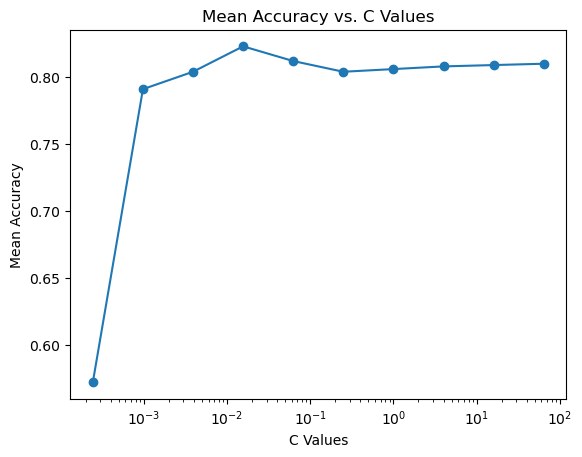

In [24]:
#Q5.3 a continued
import matplotlib.pyplot as plt
plt.plot(C_array, mean_C_val, marker='o')
plt.xlabel('C Values')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. C Values')
plt.xscale('log')
plt.show()
#

5.3 a 
From this graph it is obvious that as C values increases from 0.000244141 to 0.015625, the mean accuracy increases from 0.572 to 0.823(peak on the graph), whcih corresponds to the highest mean accuracy. When C value keeps increasing from 015625 to 64, mean accuracy overall decreases with slight increases/decreases, which are attributed to fluctuatuins. Since C controls the amount of penalizations for misclassifications, the smaller the C, the more missclassifications can be observed since model's margins are too flexible, and less sensitive to outliers. On contrary, when C takes on the large values, the problem turns into hard SVM problem, which penalizes too much for any misclassifications.As C increases, so does the accuracy, however above C = 0.015625, the accuracy of prediction decreases since we penalize model too much for the outliers. 


In [27]:
#5.3 b
index = np.argmax(mean_C_val)
print("Based on the averaged cross-validation accuracy, the highest averaged cross-validation accuracy %.3f is achieved when %0.5f C value used"%(mean_C_val[index],C_array[index]))

Based on the averaged cross-validation accuracy, the highest averaged cross-validation accuracy 0.823 is achieved when 0.01562 C value used


In [21]:
#5.3 c
# use given C value and report test accuracy on cross validation
# and on whole test data
w_temp, b_temp = train_svm(x_train_c, y_train, C_array[index]);
accuracy_temp = test_svm(x_test_c, y_test, w_temp, b_temp);
print("Best averaged cross-validation accuracy is achieved when %0.5f C value is used is %0.5f "%(C_array[index],mean_C_val[index]))

print("Best test accuracy is achieved when %0.5f C value is used is %0.5f "%(C_array[index],accuracy_temp))


     pcost       dcost       gap    pres   dres
 0:  3.8752e+00  2.8527e+02  8e+03  3e+00  2e+03
 1:  3.4376e+01 -1.1431e+02  2e+02  5e-02  3e+01
 2:  2.4307e+01 -5.5474e+00  3e+01  5e-03  4e+00
 3:  8.2811e+00  5.4476e+00  3e+00  1e-04  8e-02
 4:  7.4086e+00  6.1370e+00  1e+00  4e-05  3e-02
 5:  6.9861e+00  6.4413e+00  5e-01  2e-05  1e-02
 6:  6.7927e+00  6.5830e+00  2e-01  4e-06  3e-03
 7:  6.7264e+00  6.6340e+00  9e-02  1e-06  9e-04
 8:  6.6868e+00  6.6649e+00  2e-02  2e-07  1e-04
 9:  6.6775e+00  6.6724e+00  5e-03  1e-08  9e-06
10:  6.6749e+00  6.6746e+00  3e-04  5e-10  3e-07
11:  6.6747e+00  6.6747e+00  2e-05  2e-11  1e-08
12:  6.6747e+00  6.6747e+00  5e-07  6e-13  4e-10
Optimal solution found.
Best averaged cross-validation accuracy is achieved when 0.01562 C value is used is 0.82300 
Best test accuracy is achieved when 0.01562 C value is used is 0.84782 
